# 02_DiD_estimates.ipynb

In [10]:
from differences import ATTgt
import figure_utilities
from analysis_utilities import produce_summary_statistics
import figure_and_table_constants
from matplotlib import pyplot as plt
from scipy import stats

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [11]:
# Create dictionaries to map between string represetation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

In [12]:
# TODO: Build balance table of pretreatment characteristics.
treated_obs = df.loc[df['judgment_for_plaintiff'] == 1, :]
control_obs = df.loc[df['judgment_for_plaintiff'] == 0, :]

# Build treatment, control mean columns and add recoded variables to treatment and control DataFrames in memory.
pd.options.mode.chained_assignment = None
# Return treatment means and add covariate columns.
treatment_means = produce_summary_statistics(treated_obs, 'file_date').loc[["Panel A: Case Initiation",
                                                                        "Panel C: Defendant and Plaintiff Characteristics",
                                                                        "Panel D: Assessor Records",
                                                                            "Panel E: Census Tract Characteristics"], ['mean', 'count']]
treatment_means = treatment_means.rename(columns={'mean': "Cases Won by Plaintiff"})
# Return control means and add covariate columns to the control D.F. in memory.
control_means = produce_summary_statistics(control_obs, 'file_date').loc[["Panel A: Case Initiation",
                                                                      "Panel C: Defendant and Plaintiff Characteristics",
                                                                      "Panel D: Assessor Records",
                                                                          "Panel E: Census Tract Characteristics"], ['mean', 'count']]
pd.options.mode.chained_assignment = 'warn'

# Build unweighted columns.
difference_unadjusted = treatment_means.loc[:, 'Cases Won by Plaintiff'] - control_means.loc[:, 'mean']
N = (treatment_means.loc[:, 'count'] + control_means.loc[:, 'count']).rename("N")
p_values_unadjusted = []
for covariate in treatment_means.index.get_level_values(1):
    p_values_unadjusted.append(stats.ttest_ind(treated_obs[covariate], control_obs[covariate], nan_policy='omit').pvalue)
p_values_unadjusted = pd.Series(p_values_unadjusted, index=treatment_means.index)
unweighted_columns = pd.concat([difference_unadjusted, p_values_unadjusted], axis=1)
unweighted_columns.columns = ['Unweighted', 'P-Value']
table_columns = [treatment_means.loc[:, 'Cases Won by Plaintiff'], unweighted_columns, N]
balance_table = pd.concat(table_columns, axis=1, keys=['', 'Difference in Cases Won by Defendant', ''])
pre_treatment_covariates = balance_table.index.get_level_values(1).tolist()  # Save pre-treatment covariates for use in D.R. DiD estimator.



# Rename rows.
variable_display_names_dict = {'for_cause': "For cause", 'no_cause': "No cause", 'non_payment': "Non-payment of rent",  # Panel A
                               'case_duration': "Case duration", 'defaulted': "Case defaulted", 'heard': "Case heard",  # Panel B
                               'judgment': "Money judgment", 'mediated': "Case mediated", 'dismissed': 'Case dismised', # Panel B
                               'hasAttyD': "Defendant has an attorney", 'hasAttyP': "Plaintiff has an attorney",  # Panel C
                               'isEntityD': "Defendant is an entity", 'isEntityP': "Plaintiff is an entity",  # Panel C
                               'TOTAL_VAL': "Total property value", 'BLDG_VAL': "Building value", 'LAND_VAL': "Land value",  # Panel D
                               'OTHER_VAL': "Other value",  # Panel D
                               'med_hhinc2016': 'Median household income (2016)', 'popdensity2010': 'Population density (2010)',  # Panel E
                               'rent_twobed2015': 'Median two bedroom rent (2015)', 'share_white2010': 'Portion white (2010)',  # Panel E
                               'zestimate_-5_years_relative_to_treatment': "Five years before filing date",  # Panel F
                               'zestimate_-4_years_relative_to_treatment': "Four years before filing date",  # Panel F
                               'zestimate_-3_years_relative_to_treatment': "Three years before filing date",  # Panel F
                               'zestimate_-2_years_relative_to_treatment': "Two years before filing date",  # Panel F
                               'zestimate_-1_years_relative_to_treatment': "One year before filing date",  # Panel F
                               'zestimate_0_years_relative_to_treatment': "Filing date",  # Panel F
                               'zestimate_1_years_relative_to_treatment': "One year after filing date",  # Panel F
                               'zestimate_2_years_relative_to_treatment': "Two years after filing date",  # Panel F
                               'zestimate_3_years_relative_to_treatment': "Three years after filing date"}  # Panel F
balance_table = balance_table.rename(index=variable_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .style
         .format(thousands=",",
                 formatter={('', 'Cases Won by Plaintiff'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'Unweighted'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'P-Value'): "{:,.2f}",
                            ('', 'N'): "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   multicol_align='|c|',
                   clines="skip-last;data")).replace("{*}", "{3cm}")
with open(filename, 'w') as file:
    file.write(latex)
balance_table

\
                                                                                Cases Won by Plaintiff   
Panel A: Case Initiation                         For cause                                1.241803e-01   
                                                 No cause                                 1.110656e-01   
                                                 Non-payment of rent                      7.209016e-01   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                6.598361e-02   
                                                 Plaintiff has an attorney                7.959016e-01   
                                                 Defendant is an entity                   1.188525e-02   
                                                 Plaintiff is an entity                   6.594262e-01   
Panel D: Assessor Records                        Building value                           6.554744e+06   
                                                 Land value                               1.897711e+06   
                                                 Other value                              8.758564e+04   
                                                 Total property value                     8.535626e+06   
Panel E: Census Tract Characteristics            Median household income (2016)           5.208732e+04   
                                                 Population density (2010)                9.031635e+03   
                                                 Median two bedroom rent (2015)           1.093360e+03   
                                                 Portion white (2010)                     6.020995e-01   

                                                                                Difference in Cases Won by Defendant  \
                                                                                                          Unweighted   
Panel A: Case Initiation                         For cause                                                  0.005299   
                                                 No cause                                                  -0.027629   
                                                 Non-payment of rent                                       -0.005206   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                                 -0.135648   
                                                 Plaintiff has an attorney                                  0.011519   
                                                 Defendant is an entity                                     0.003727   
                                                 Plaintiff is an entity                                     0.028890   
Panel D: Assessor Records                        Building value                                        184134.628913   
                                                 Land value                                             25986.913258   
                                                 Other value                                            22095.386351   
                                                 Total property value                                  232361.889704   
Panel E: Census Tract Characteristics            Median household income (2016)                          2566.821918   
                                                 Population density (2010)                                944.988233   
                                                 Median two bedroom rent (2015)                            34.255627   
                                                 Portion white (2010)                                       0.035089   

                                                                                               \
                                                                                      P-Value   
Panel A: Case Initiation                         For cause        

In [13]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
df = df.dropna(subset=['file_date', 'latest_docket_date'])
print(f"Limiting sample to {len(df)} evictions for which we observe the filing date and the latest docket"
      f"date.")
cases_per_year = df[treatment_year_variable].value_counts()  # Store yearly case counts for use in figure titles in next cell.

# Run produce summary statistics on the DataFrame to add pre-treatment covariate columns.
produce_summary_statistics(df, 'file_date')
# Reshape from wide to long.
df = pd.melt(df,
             id_vars=['case_number', treatment_month_variable, treatment_year_variable, 'judgment_for_plaintiff'] + pre_treatment_covariates,
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, treatment_month_variable] = df[treatment_month_variable].replace(month_to_int_dictionary)

# Set treatment month to 0 for untreated observations.
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, treatment_month_variable] = np.NaN
df.loc[never_treated_mask, treatment_year_variable] = np.NaN

# Generate numeric version of case_number.
df.loc[:, 'case_number_numeric'] = df['case_number'].astype('category').cat.codes

# Set index.
df = df.set_index(['case_number', 'month'])

Limiting sample to 2964 evictions for which we observe the filing date and the latest docketdate.


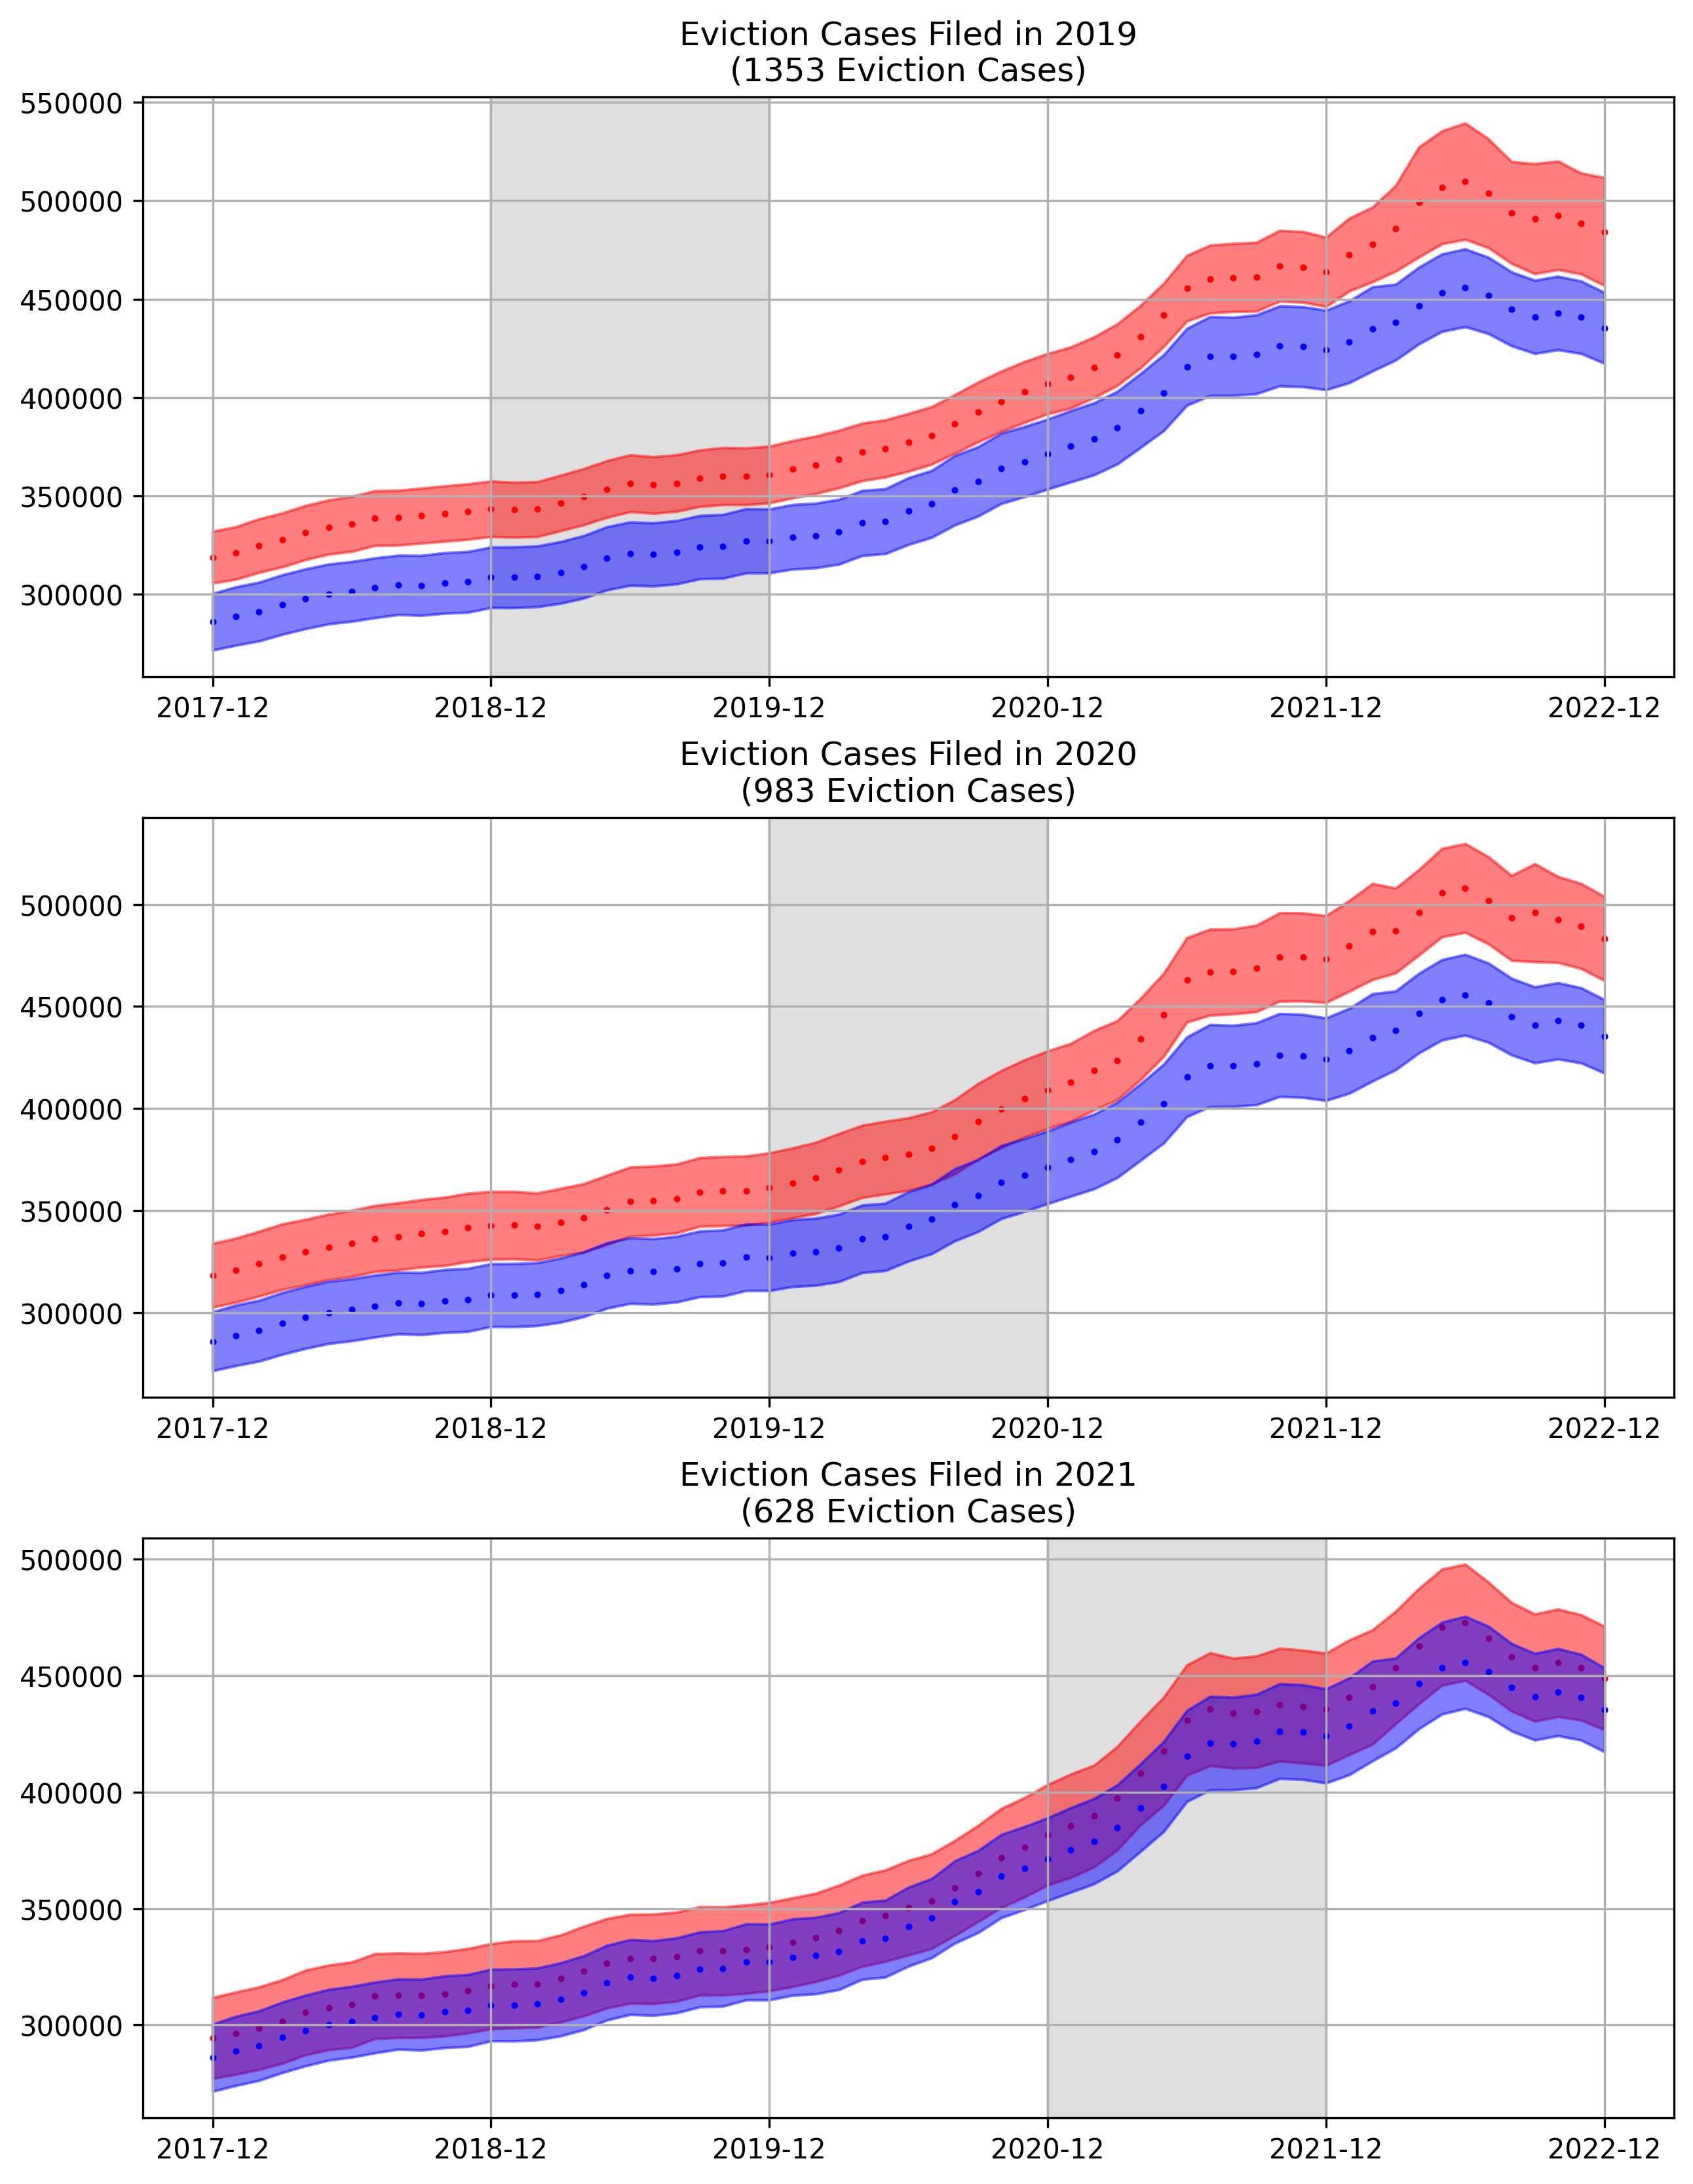

In [14]:
# Plot path of outcomes in treated group vs. control group, separately by year of filing.
# Plot.
aggregated_zestimates = (df
                         .copy().loc[(slice(None), slice(60, 120)), ]
                         .groupby([treatment_year_variable, 'month'], dropna=False)['zestimate']
                         .agg([np.mean, np.std, 'count']))
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96 * aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96 * aggregated_zestimates['se']
treatment_times = aggregated_zestimates.index.get_level_values(treatment_year_variable).unique()
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8.5, 11))
for ax, aggregated_cohort in zip(axes, treatment_times):
    # No need to plot trends for untreated cohort.
    if np.isnan(aggregated_cohort):
        continue
    # Shade months during which treatment occurred in each aggregated cohort.
    start_shading = 12*(int(aggregated_cohort) - 2017 - 1)
    end_shading = start_shading + 12
    ax.axvspan(start_shading, end_shading, color=figure_and_table_constants.Colors.LABELING_COLOR,
               alpha=0.25)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values

    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_treatment,
                                                     y_treatment,
                                                     y_upper_treatment,
                                                     y_lower_treatment,
                                                     point_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     error_color=figure_and_table_constants.Colors.TREATMENT_COLOR)

    sub_df_control = (aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values(treatment_year_variable)
                                                .isna(), :])
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_control,
                                                     y_control,
                                                     y_upper_control,
                                                     y_lower_control,
                                                     point_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     error_color=figure_and_table_constants.Colors.CONTROL_COLOR)
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.grid(True)


    if treatment_date_variable == 'file_date':
        verb = 'Filed'
    elif treatment_date_variable == 'latest_docket_date':
        verb = 'Concluded'
    else:
        raise ValueError("Invalid treatment_date_variable.")
    ax.set_title(f"Eviction Cases {verb} in {int(aggregated_cohort)}\n"
                 f"({cases_per_year.loc[int(aggregated_cohort)]} Eviction Cases)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates_by_cohort.png"))

In [ ]:
# Run DiD without conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   18%|███▌                | 541/3000 [00:21<01:20, 30.65it/s]

In [ ]:
# Get event study-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-8:24]
results_df.columns = results_df.columns.droplevel().droplevel()

# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Treatment Month", color='black', linestyle='-',
                                    text_y_location_normalized=0.95)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-')
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower,
                                              point_color='black',
                                              error_color='black')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_event_study.png"))


In [ ]:
# Get time-aggregated ATTs.
results_df = att_gt.aggregate('time')

# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
results_df = results_df.rename(index=int_to_month_dictionary)
x = results_df.index
y = results_df.iloc[:, 0]
y_upper = results_df.iloc[:, 3]
y_lower = results_df.iloc[:, 2]
ax.set_xlabel("Month")
ax.set_ylabel("ATT")
ax.set_title("Unconditional Estimates of ATT(g, t), Aggregated by Month")
figure_utilities.plot_labeled_vline(ax, x=results_df.index.tolist()[0], text="Earliest Treatment Date in Sample", color='black', linestyle='-',
                                    text_y_location_normalized=0.95)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-')
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower,
                                              point_color='black',
                                              error_color='black')
ax.set_xticks(range(0, len(x), 12))
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_time.png"))


In [ ]:
# Run DiD conditional on covariates.
[pre_treatment_covariates.remove(var) for var in ['BLDG_VAL', 'LAND_VAL', 'OTHER_VAL', 'TOTAL_VAL', 'rent_twobed2015',
                                                  'transfer', 'foreclosure', 'isEntityD']]
df = df.dropna(subset=pre_treatment_covariates)
print(pre_treatment_covariates)
print(len(df))
df.loc[:, 'med_hhinc2016'] = np.log(df['med_hhinc2016'])
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = 'zestimate ~ ' + '+'.join(pre_treatment_covariates)
print(formula)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

In [ ]:
# Get cohort-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-8:24]
results_df.columns = results_df.columns.droplevel().droplevel()

# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("Conditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Treatment Month", color='black', linestyle='-',
                                    text_y_location_normalized=0.95)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-')
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower,
                                              point_color='black',
                                              error_color='black')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_estimates_event_study.png"))
